<a href="https://colab.research.google.com/github/cristianocapone/RL_ML_class/blob/main/training_ant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "gymnasium[mujoco]"
!pip install glfw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 455.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 13.3 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import numpy as np

import matplotlib.pyplot as plt
import pickle

from tqdm import trange
from matplotlib.animation import ArtistAnimation

In [13]:
class net:

    def __init__ (self, par):
        # This are the network size N, input I, output O and max temporal span T
        self.N, self.I, self.O, self.T = par['shape']
        net_shape = (self.N, self.T)

        self.dt = par['dt']#1. / self.T;
        self.itau_m = self.dt / par['tau_m']
        self.tau_m = par['tau_m']
        self.tau_m = np.logspace( np.log(par['tau_m']*.5) ,np.log(par['tau_m']*2.),self.N)

        self.itau_s = np.exp (-self.dt / par['tau_s'])
        self.itau_ro = np.exp (-self.dt / par['tau_ro'])
        self.dv = par['dv']

        # This is the network connectivity matrix
        self.J = np.random.normal (0., par['sigma_rec'], size = (self.N, self.N))

        # This is the network input, teach and output matrices
        self.Jin = np.random.normal (0., par['sigma_input'], size = (self.N, self.I))
        self.Jout = np.random.normal (0.0, par['sigma_output'], size = (self.O,self.N))
        self.dJfilt = np.zeros(np.shape(self.J))
        self.dJfilt_out = np.zeros(np.shape(self.Jout))
        self.dJout_aggregate = np.zeros(np.shape(self.Jout))
        self.S_filt_tot = np.zeros(self.N,)
        self.r=0

        self.name = 'model'

        # This is the external field
        h = par['h']

        assert type (h) in (np.ndarray, float, int)
        self.h = h if isinstance (h, np.ndarray) else np.ones (self.N) * h

        # These are the spikes train and the filtered spikes train
        self.S = np.zeros (self.N)

        # Here we save the params dictionary
        self.par = par

    def step (self, inp, if_spk = False,if_tanh = False):
        self.S   = self.S   * np.exp( - self.dt/self.tau_m) + (1.-np.exp( -self.dt/self.tau_m)) * (self.J @ self.S   + self.Jin @ inp + self.h)
        self.y = self.Jout@self.S

    def policy (self,if_derive_var=False):
        self.mu = np.tanh(self.y)
        if if_derive_var:
            self.act_variance = np.copy(self.sigma)
        self.action = self.mu + np.random.normal (0., self.act_variance, size = ( self.O,))

    def reset (self, init = None):
        self.S   = init if init else np.zeros (self.N)
        self.dJfilt *= 0
        self.dJfilt_out *= 0

    def update_J (self,l2_out=0.001):

        self.Jout = self.adam_out.step (self.Jout, self.dJout_aggregate - l2_out*self.Jout )

        self.dJ_aggregate=0
        self.dh_aggregate=0
        self.dJout_aggregate=0
        self.dJout_sigma_aggregate=0
        self.S_filt_tot=0


    def learn_error (self, r ):

            alpha_J = 1-self.gamma
            dmu = (self.action - self.mu)*(1.-self.mu**2)

            self.dJout_aggregate += r*self.dJfilt_out
            dJ_out = np.zeros((self.O,self.N))
            dJ_out = np.outer(dmu, self.S.T)

            self.dJfilt_out = self.dJfilt_out*(1-alpha_J) + dJ_out
            self.grad = np.copy(r*self.dJfilt_out)
            self.dJout_aggregate += (r*self.dJfilt_out)
            self.dh = 0

# This is a very simple class to implement the Adam Optimizer
class Adam:
    def __init__ (self, alpha = .001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-5,
                  drop = 0.8, drop_time = 5000):
        self.alpha = alpha
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.drop = drop
        self.drop_time = drop_time

        self.m = 0.
        self.v = 0.

        self.t = 0

    def step (self, theta_t, g_t, step_time = True):
        #if self.t % self.drop_time == 0:
        #self.alpha *= self.drop
        self.t += 1

        self.m = self.beta_1 * self.m + (1. - self.beta_1) * g_t
        self.v = self.beta_2 * self.v + (1. - self.beta_2) * g_t**2

        m_hat = self.m / (1. - self.beta_1**self.t)
        v_hat = self.v / (1. - self.beta_2**self.t)

        #if step_time:

        #print( self.alpha)
        return theta_t + self.alpha * m_hat / (np.sqrt (v_hat) + self.epsilon)

    # This is the Adam optimization
    def optimize (self, grad, *args, init = 0., t_max = 1000):
        # Initialize time step and moment estimations
        self.m = 0.
        self.v = 0.

        theta = init

        for t in range (1, t_max):
            if t % self.drop_time == 0:
                self.alpha *= self.drop

            g_t = grad (theta, *args)

            # First we update the first and second moment gradient estimate
            self.m = self.beta_1 * self.m + (1. - self.beta_1) * g_t
            self.v = self.beta_2 * self.v + (1. - self.beta_2) * g_t**2

            # Compute bias-corrected estimate for first and second moment
            m_hat = self.m / (1. - self.beta_1**t)
            v_hat = self.v / (1. - self.beta_2**t)

            theta += self.alpha * m_hat / (np.sqrt (v_hat) + self.epsilon)

        return theta


/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment Ant-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


Observation Space: Box(-inf, inf, (27,), float64)
Action Space: Box(-1.0, 1.0, (8,), float32)


100%|██████████| 1000/1000 [00:46<00:00, 21.51it/s]


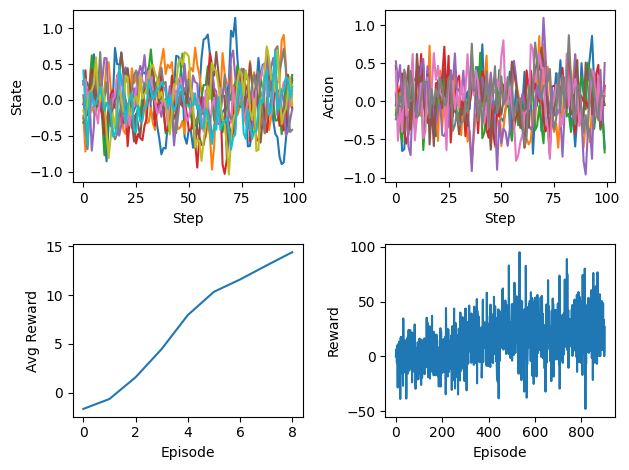

In [14]:
plt.rcParams['animation.html'] = 'jshtml'

# Create the environment using MuJoCo's Ant environment
env = gym.make('Ant-v4')

print(f'Observation Space: {env.observation_space}')
print(f'Action Space: {env.action_space}')

render_every = 100000
n_episodes= 1000
# Parameters
if_load = False
act_variance =  0.25
episode_duration = 100

out_dim=8


N, I, O, T = 500, 27 , out_dim, 100
shape = (N, I, O, T)

dt = 0.001
tau_m = 5. * dt
tau_s = 2. * dt
tau_ro = 3. * dt
beta_s = np.exp(-dt / tau_s)
beta_ro = np.exp(-dt / tau_ro)
sigma_teach = 5.0
sigma_input = .01
sigma_output = 0.01
offT = 1
dv = 1 / 5.
alpha = 0.5
alpha_rout = 0.0005
alpha_pg = 0.0005
Vo = 0.
h = 0.
s_inh = 20

# Simulation parameters
par = {'tau_m': tau_m, 'tau_s': tau_s, 'tau_ro': tau_ro, 'beta_ro': beta_ro,
       'dv': dv, 'alpha': alpha, 'Vo': Vo, 'h': h, 's_inh': s_inh,
       'N': N, 'T': T, 'dt': dt, 'offT': offT, 'alpha_rout': alpha_rout,
       'sigma_input': sigma_input, 'sigma_teach': sigma_teach, 'shape': shape, 'sigma_output': sigma_output}

par['sigma_rec'] = .95/np.sqrt(N)

n_repeats = 1

for repeats in range(n_repeats):

    network = net(par)

    if if_load:
        with open('transfer.pickle', 'rb') as f:
            network = pickle.load(f)
    network.act_variance = act_variance#*.25

    network.adam_out = Adam(alpha=0.0001, drop=0.99, drop_time=10000)
    network.gamma = 0.99

    network.out_dim=out_dim

    # Main loop
    REWARDS = []
    R_AVG = []

    n_movie = 0

    for iterations in trange(n_episodes):

        last_avg_reward = 0

        if_render = (iterations % render_every == 0) and (iterations > 0)
        env.reset()

        frames = []
        S = []

        obs, r, done, _, _ = env.step(np.zeros(8,))
        r_tot = 0

        if if_render:
            fig, ax = plt.subplots(figsize=(4, 5))
            ax.axis('off')
            fig.patch.set_alpha(0.)
            fig.tight_layout()

        network.reset()
        collections = dict(pred_values=[], rewards=[], a=[],action=[],musub1=[],musub2=[])

        for k in range(episode_duration):

            network.step(obs)
            network.policy()
            obs, r, done, _, _ = env.step(network.action)

            r = np.copy(obs[13])
            r_tot += r

            network.learn_error(r-last_avg_reward*0)

            collections['rewards'].append(r)
            collections['action'].append(network.action)

            S.append(network.S)

            if done:
                break

            if if_render:
                IMG = env.render()
                frames += [(ax.imshow (IMG),)]

        REWARDS.append(r_tot)

        if (iterations % 1 == 0) and (iterations > 0):
            network.update_J(l2_out=0.)

        if (iterations % 100 == 0) and (iterations > 0):

            last_avg_reward = np.mean(REWARDS[-1000:])
            R_AVG.append(np.mean(REWARDS[-1000:]))

            plt.figure(0)
            plt.clf()
            plt.subplot(221)
            plt.plot(np.array(S).T[:10, :].T)
            plt.xlabel('Step')
            plt.ylabel('State')

            plt.subplot(222)
            plt.plot(collections['action'])
            plt.xlabel('Step')
            plt.ylabel('Action')

            plt.subplot(223)
            plt.plot(R_AVG)
            plt.xlabel('Episode')
            plt.ylabel('Avg Reward')

            plt.subplot(224)
            plt.plot(REWARDS)
            plt.xlabel('Episode')
            plt.ylabel('Reward')

            plt.tight_layout()
            plt.savefig('rewards_ant_hier_transfer.png')


            with open('transfer_new.pickle', 'wb') as f:
                pickle.dump(network, f)

        # Save the video if rendering
        if if_render:
            ant_sac_anim  = ArtistAnimation(fig, frames,  interval = 50, blit = True)
            ant_sac_anim.save('AntMujocoEnv-v4' + str(n_movie) + '.mp4', dpi = 600)
            n_movie = n_movie + 1
            render_every = render_every*2

    np.save(f'trajectory_{repeats}.npy', R_AVG)